In [1]:
from graph_generating_script import *
from choosing_best_num_algorithms import *

# TODO

In [ ]:

#

In [ ]:
import random
import numpy as np

random.seed(212)
np.random.seed(212)


In [25]:
(G, true_labels) = generate_G_randomized(50, 2, .5, .05)
pos = nx.kamada_kawai_layout(G)
posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
nx.numeric_assortativity_coefficient(G, "community")

0.7704203283602427

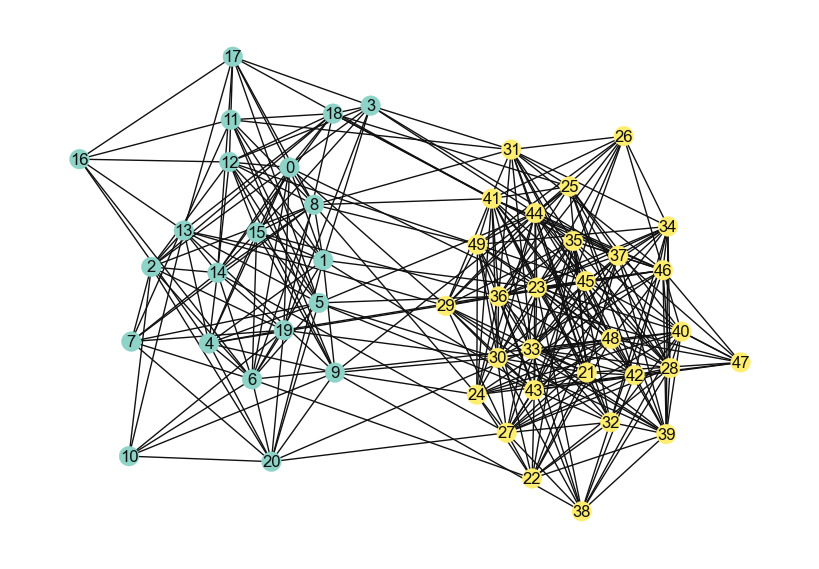

In [26]:
nx.draw(G, node_color=true_labels, cmap=plt.cm.Set3, with_labels=True, node_size=200)

In [135]:
df_all_results = pd.read_csv('data/all_results.csv')
tmp = df_all_results[df_all_results['no_communities']==6]
print(min(tmp['assortativity']))
# print(max(tmp['assortativity']))


0.3799295445334658


# Analysis from results

### Gry plan:

##### Analiza ogólna: 

* skleić wszystkie ramki razem
* dla każdej policzyc róznice z ground truth (ze znakiem)
* zrobić analize tyh błedów jaki boxplot (jak blisko zera są)
* zrobic te historam tych wartości
* może jakieś podsumowanie procentowe (albo po prostu rmse) który z tych algorytmów myli sie najmniej



In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
wake_up_and_its_over = ['#62B8CE','#605E04', '#E5510D','#885B59','#892203']
mammalian_sighting_reflex = ['#C0000D','#17195C','#91A3B5','#0F0F29','#510C2D']

# Set the custom palette in Seaborn
sns.set_palette(mammalian_sighting_reflex)

# Set the custom palette in Matplotlib
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=mammalian_sighting_reflex)


In [20]:
import os
import pandas as pd

#@ adding bestnum_algo names as a column to the results files
# Define the input and output directories
input_dir = 'data'
output_dir = 'bestnum_results'

files = [f for f in os.listdir(input_dir) if f.endswith('_results.xlsx')]

for file in files:
    file_path = os.path.join(input_dir, file)
    df = pd.read_excel(file_path)
    name_part = file.split('_')[1]
    if name_part =='ch':
        name_part = 'calinski_harabasz'
    if name_part == 'gap':
        name_part = 'gap_statistic'
    df['bestnum_algo'] = name_part
    output_file_path = os.path.join(output_dir, file)
    df.to_excel(output_file_path, index=False)

print("Files processed and saved successfully.")

Files processed and saved successfully.


In [21]:
df_all_results = pd.DataFrame()
input_dir = 'bestnum_results'
files = [f for f in os.listdir(input_dir) if f.endswith('_results.xlsx')]

for file in files:
    file_path = os.path.join(input_dir, file)
    df = pd.read_excel(file_path)
    df_all_results = pd.concat([df_all_results, df])

In [22]:
df_all_results['diff'] = df_all_results['calculated_bestnum'] - df_all_results['no_communities']
df_all_results['abs_diff'] = abs(df_all_results['diff'])

In [25]:
df_all_results.to_csv('data/all_results.csv', index=False)

In [115]:
df_all_results = df_all_results[df_all_results['layout_name'] == 'graphopt']

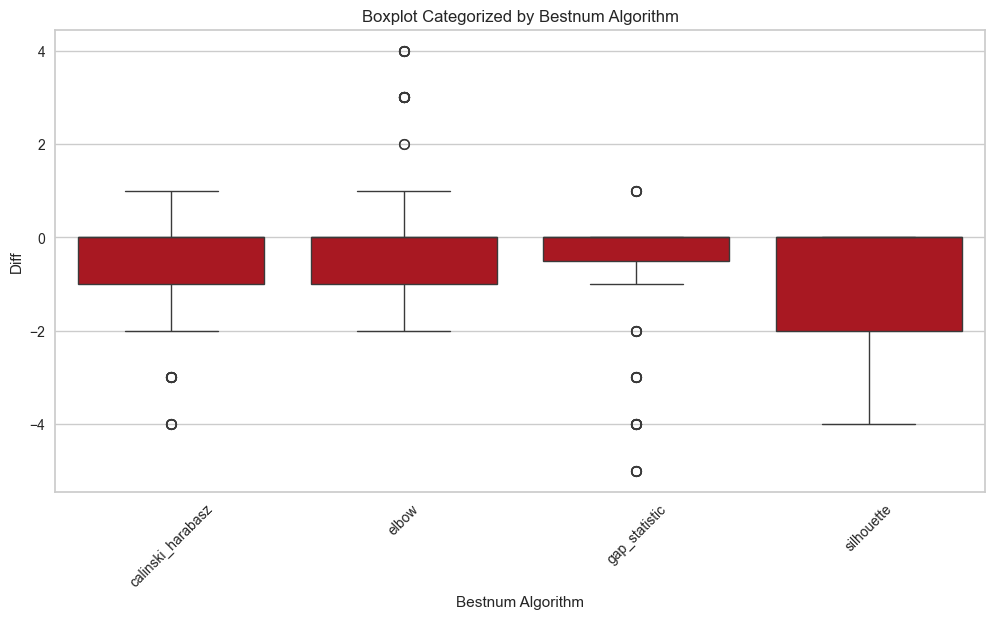

In [116]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='bestnum_algo', y='diff', data=df_all_results)

# Customize the plot
plt.title('Boxplot Categorized by Bestnum Algorithm')
plt.xlabel('Bestnum Algorithm')
plt.ylabel('Diff')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.show()

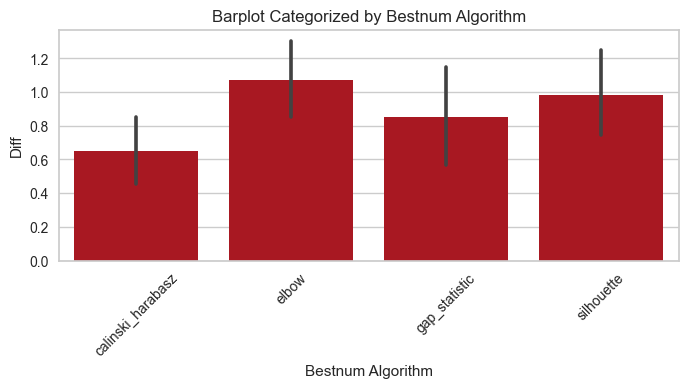

In [117]:
plt.figure(figsize=(8, 3))
sns.barplot(x='bestnum_algo', y='abs_diff', data=df_all_results,estimator=np.mean)

# Customize the plot
plt.title('Barplot Categorized by Bestnum Algorithm')
plt.xlabel('Bestnum Algorithm')
plt.ylabel('Diff')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.show()

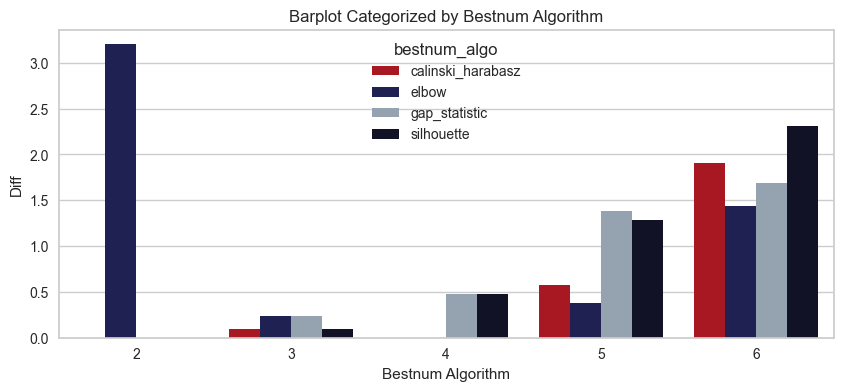

In [118]:
plt.figure(figsize=(10, 4))
sns.barplot(x='no_communities', y='abs_diff', hue='bestnum_algo', data=df_all_results, estimator=np.mean, palette=mammalian_sighting_reflex, ci=None)

# Customize the plot
plt.title('Barplot Categorized by Bestnum Algorithm')
plt.xlabel('Bestnum Algorithm')
plt.ylabel('Diff')
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.show()

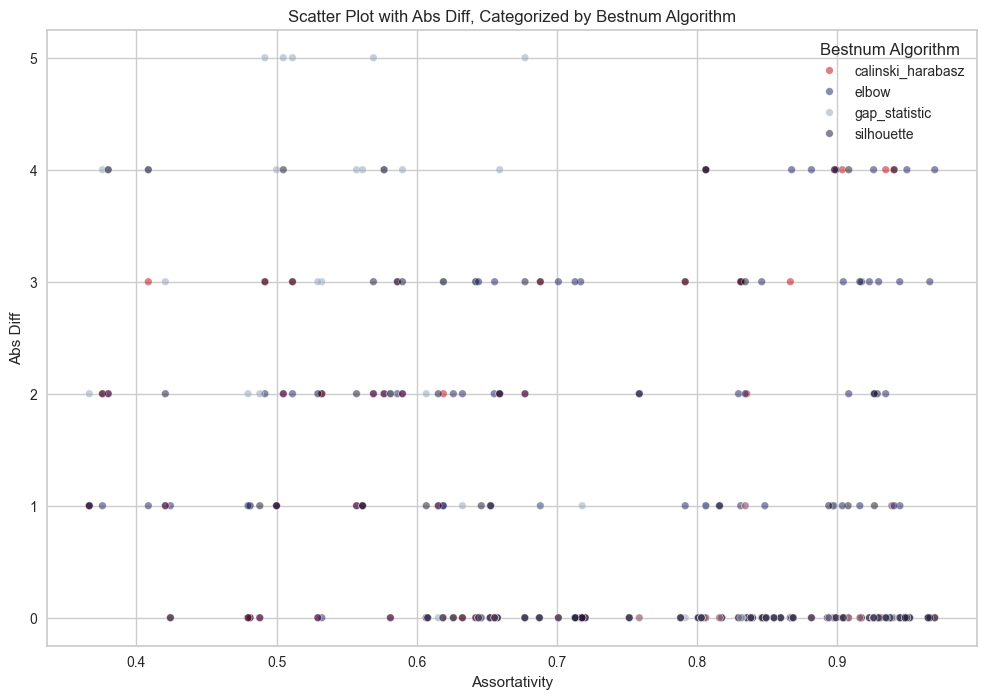

In [119]:
plt.figure(figsize=(12,8))
scatter = sns.scatterplot(x='assortativity', y='abs_diff', hue='bestnum_algo', data=df_all_results[df_all_results['layout_name']=='graphopt'], 
                          palette=mammalian_sighting_reflex, s=30, alpha=.5)

# Customize the plot
plt.title('Scatter Plot with Abs Diff, Categorized by Bestnum Algorithm')
plt.xlabel('Assortativity')
plt.ylabel('Abs Diff')
plt.legend(title='Bestnum Algorithm')

# Show the plot
plt.show()

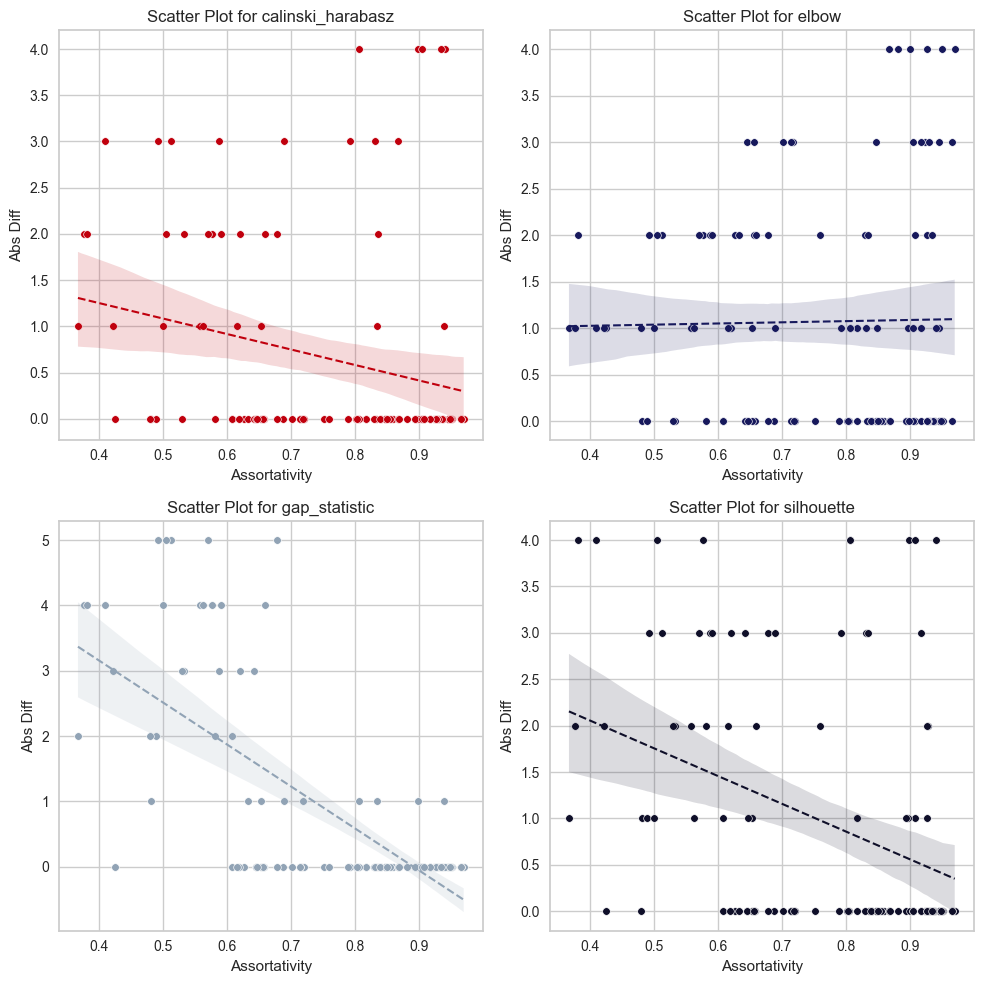

In [121]:
palette_dict = dict(zip(df_all_results['bestnum_algo'].unique(), mammalian_sighting_reflex))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Get unique bestnum_algo values
unique_algos = df_all_results['bestnum_algo'].unique()

# Iterate over each subplot and unique bestnum_algo
for ax, algo in zip(axes, unique_algos):
    # Filter data for the current bestnum_algo
    subset = df_all_results[df_all_results['bestnum_algo'] == algo]
    
    # Create the scatter plot
    sns.scatterplot(x='assortativity', y='abs_diff', data=subset, ax=ax, color=palette_dict[algo], s=30)
    sns.regplot(x='assortativity', y='abs_diff', data=subset, ax=ax, scatter=False, color=palette_dict[algo], line_kws={"linestyle": "--", "linewidth": 1.5})

    # Customize the subplot
    ax.set_title(f'Scatter Plot for {algo}')
    ax.set_xlabel('Assortativity')
    ax.set_ylabel('Abs Diff')

plt.tight_layout()
plt.show()

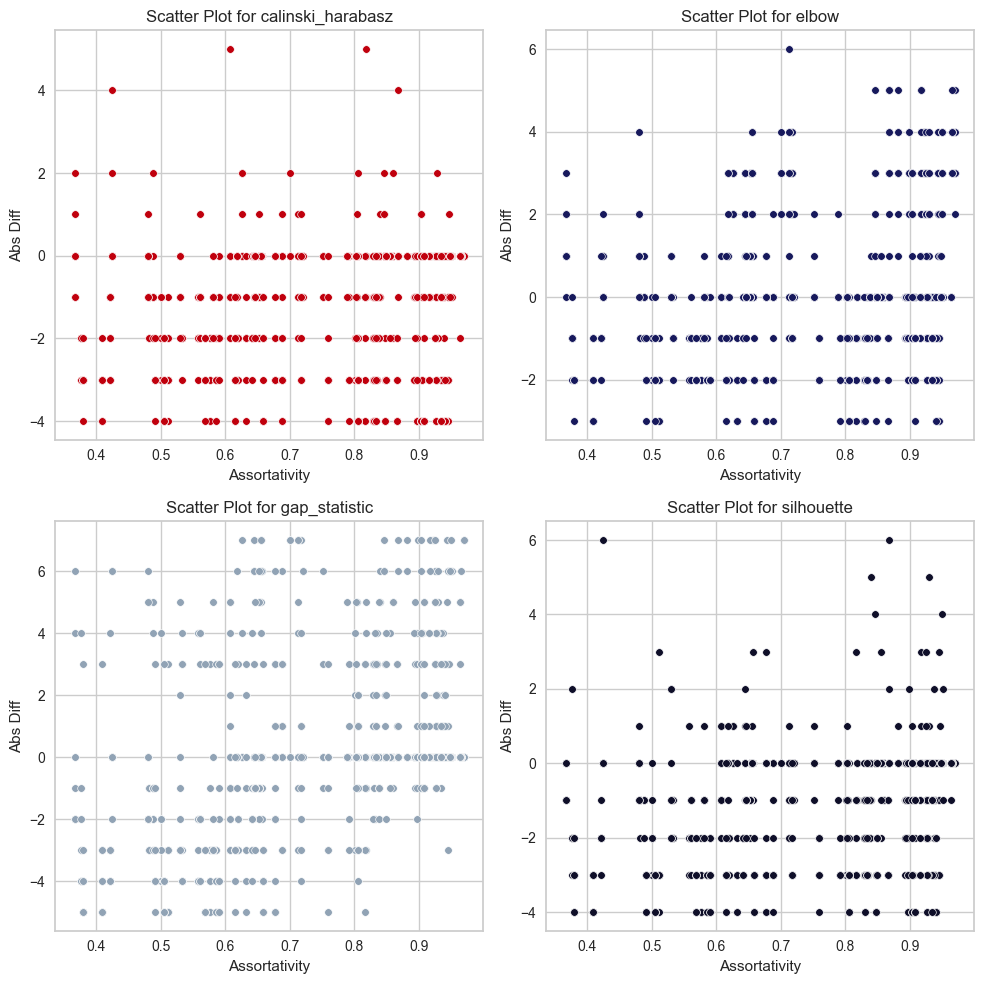

In [109]:
palette_dict = dict(zip(df_all_results['bestnum_algo'].unique(), mammalian_sighting_reflex))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

unique_algos = df_all_results['bestnum_algo'].unique()

for ax, algo in zip(axes, unique_algos):
    # Filter data for the current bestnum_algo
    subset = df_all_results[df_all_results['bestnum_algo'] == algo]
    
    # Create the scatter plot
    sns.scatterplot(x='assortativity', y='diff', data=subset, ax=ax, color=palette_dict[algo], s=30)
    # sns.regplot(x='assortativity', y='abs_diff', data=subset, ax=ax, scatter=False, color=palette_dict[algo], line_kws={"linestyle": "--", "linewidth": 1.5})

    # Customize the subplot
    ax.set_title(f'Scatter Plot for {algo}')
    ax.set_xlabel('Assortativity')
    ax.set_ylabel('Abs Diff')

plt.tight_layout()
plt.show()

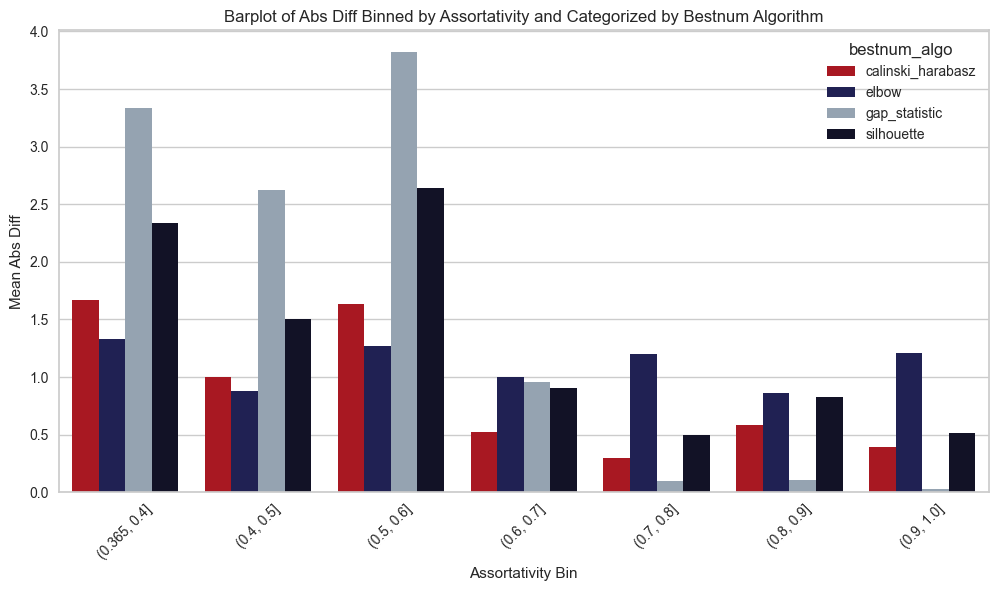

In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_all_results is already loaded and contains the 'bestnum_algo', 'abs_diff', and 'assortativity' columns

# Define the custom palette
palette_dict = dict(zip(df_all_results['bestnum_algo'].unique(), mammalian_sighting_reflex))

# Define bins with specific edges
bins = np.arange(0.4, df_all_results['assortativity'].max() + 0.1, 0.1)
bins = np.insert(bins, 0, df_all_results['assortativity'].min())  # Ensure the first bin starts from the minimum value

# Bin the 'assortativity' values
df_all_results['assortativity_bin'] = pd.cut(df_all_results['assortativity'], bins=bins, include_lowest=True)

# Calculate the mean of 'abs_diff' for each bin and 'bestnum_algo'
binned_data = df_all_results.groupby(['assortativity_bin', 'bestnum_algo']).agg({'abs_diff': 'mean'}).reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='assortativity_bin', y='abs_diff', hue='bestnum_algo', data=binned_data, palette=mammalian_sighting_reflex, ci=None)

# Customize the plot
plt.title('Barplot of Abs Diff Binned by Assortativity and Categorized by Bestnum Algorithm')
plt.xlabel('Assortativity Bin')
plt.ylabel('Mean Abs Diff')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

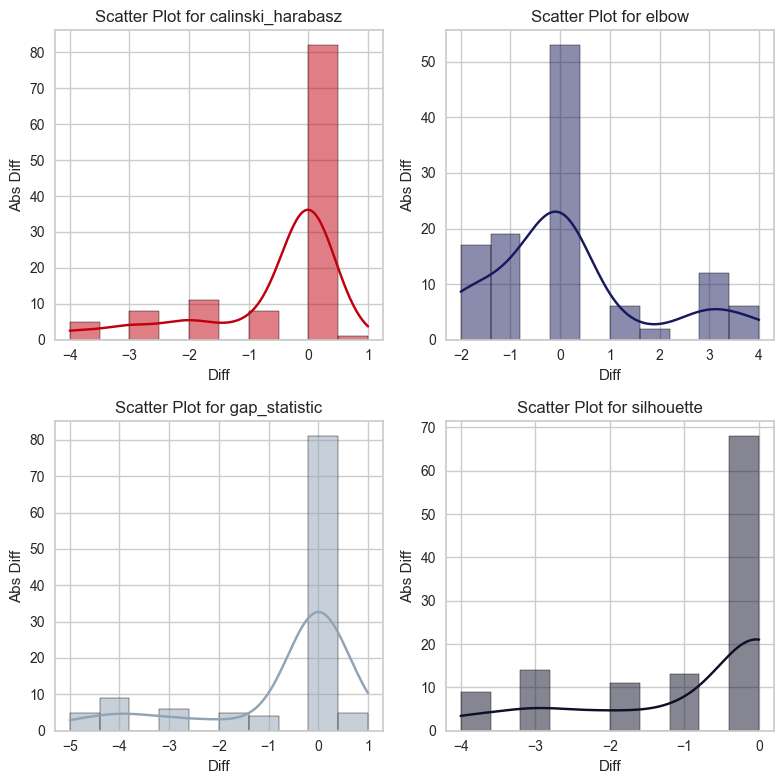

In [123]:
palette_dict = dict(zip(df_all_results['bestnum_algo'].unique(), mammalian_sighting_reflex))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Get unique bestnum_algo values
unique_algos = df_all_results['bestnum_algo'].unique()

# Iterate over each subplot and unique bestnum_algo
for ax, algo in zip(axes, unique_algos):
    # Filter data for the current bestnum_algo
    subset = df_all_results[df_all_results['bestnum_algo'] == algo]
    
    # Create the scatter plot
    # sns.scatterplot(x='assortativity', y='abs_diff', data=subset, ax=ax, color=palette_dict[algo], s=30)
    # sns.regplot(x='assortativity', y='abs_diff', data=subset, ax=ax, scatter=False, color=palette_dict[algo], line_kws={"linestyle": "--", "linewidth": 1.5})
    sns.histplot(data=subset, x='diff', bins=10, kde=True, ax=ax, color=palette_dict[algo])
    # Customize the subplot
    ax.set_title(f'Scatter Plot for {algo}')
    ax.set_xlabel('Diff')
    ax.set_ylabel('Abs Diff')

plt.tight_layout()
plt.show()

In [ ]:
# analyzing the influence of layout algorithm

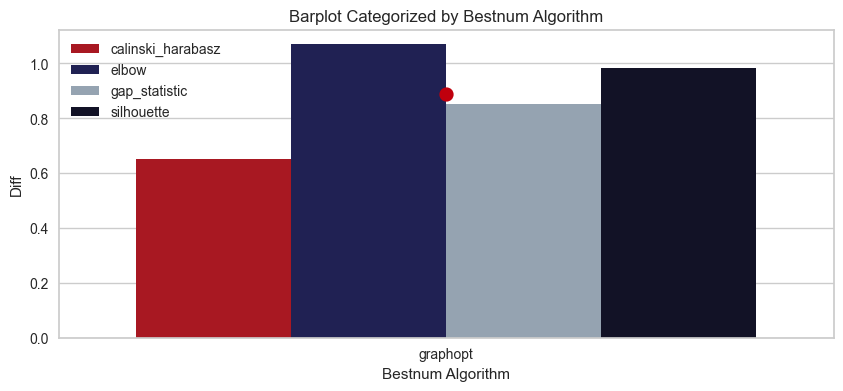

In [124]:

#todo reaload df all results here
plt.figure(figsize=(10, 4))
sns.barplot(x='layout_name', y='abs_diff', hue='bestnum_algo', data=df_all_results, estimator=np.mean, palette=mammalian_sighting_reflex.append(wake_up_and_its_over), ci=None)
general_avg = df_all_results.groupby('layout_name')['abs_diff'].mean().reset_index()
sns.pointplot(x='layout_name', y='abs_diff', data=general_avg, color=mammalian_sighting_reflex[0], markers='o', linestyles='')
# Customize the plot
plt.title('Barplot Categorized by Bestnum Algorithm')
plt.xlabel('Bestnum Algorithm')
plt.ylabel('Diff')
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.show()

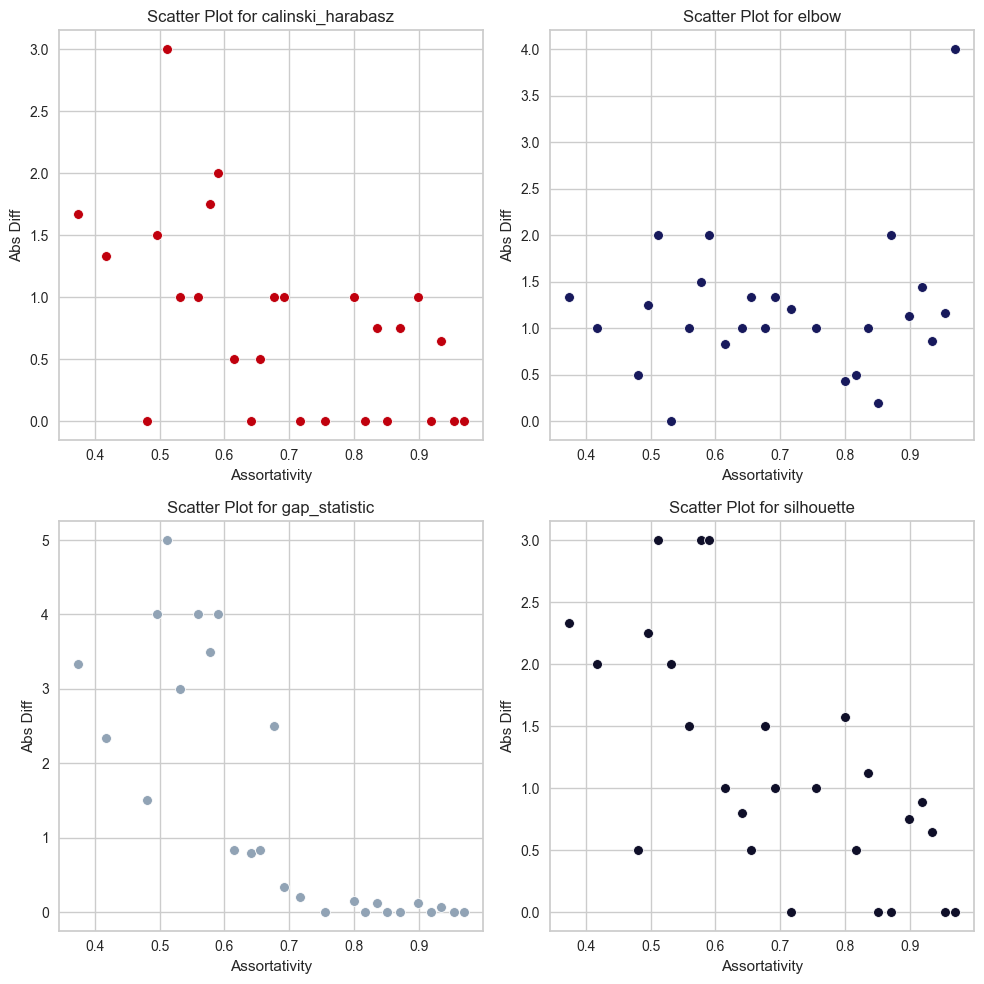

In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_all_results is already loaded and contains the 'bestnum_algo', 'assortativity', and 'abs_diff' columns

# Define the custom palette
palette_dict = dict(zip(df_all_results['bestnum_algo'].unique(), mammalian_sighting_reflex))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Get unique bestnum_algo values
unique_algos = df_all_results['bestnum_algo'].unique()

# Define bins with a width of 0.05
bins = np.arange(df_all_results['assortativity'].min(), df_all_results['assortativity'].max() + 0.02, 0.02)

# Iterate over each subplot and unique bestnum_algo
for ax, algo in zip(axes, unique_algos):
    # Filter data for the current bestnum_algo
    subset = df_all_results[df_all_results['bestnum_algo'] == algo]
    
    # Bin the 'assortativity' values
    subset['assortativity_bin'] = pd.cut(subset['assortativity'], bins=bins, include_lowest=True)
    
    # Calculate the mean of 'abs_diff' for each bin
    binned_data = subset.groupby('assortativity_bin').agg({'assortativity': 'mean', 'abs_diff': 'mean'}).reset_index()
    
    # Create the scatter plot
    sns.scatterplot(x='assortativity', y='abs_diff', data=binned_data, ax=ax, color=palette_dict[algo], s=50)
    # sns.regplot(x='assortativity', y='abs_diff', data=binned_data, ax=ax, scatter=False, color=palette_dict[algo], line_kws={"linestyle": "--", "linewidth": 1.5})

    # Customize the subplot
    ax.set_title(f'Scatter Plot for {algo}')
    ax.set_xlabel('Assortativity')
    ax.set_ylabel('Abs Diff')

plt.tight_layout()
plt.show()

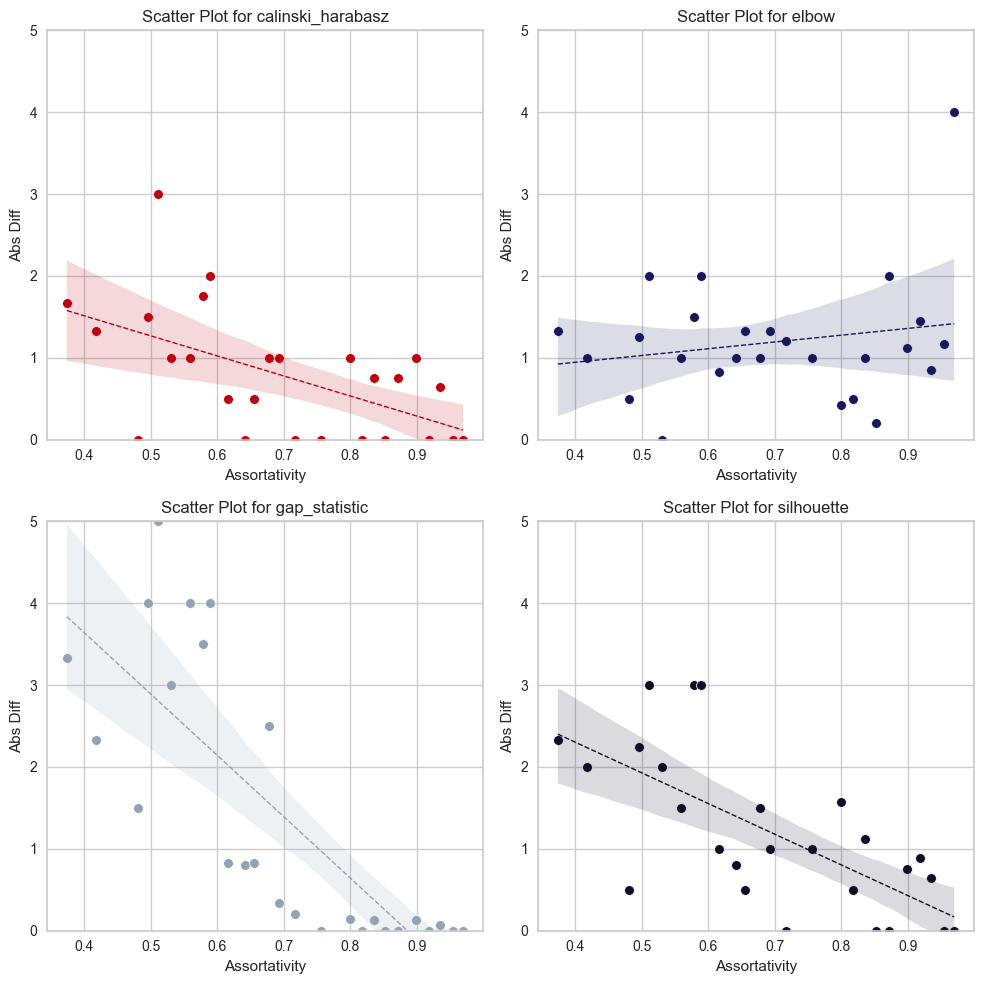

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df_all_results is already loaded and contains the 'bestnum_algo', 'assortativity', and 'abs_diff' columns

# Define the custom palette
palette_dict = dict(zip(df_all_results['bestnum_algo'].unique(), mammalian_sighting_reflex))

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Get unique bestnum_algo values
unique_algos = df_all_results['bestnum_algo'].unique()

# Define bins with a width of 0.05
bins = np.arange(df_all_results['assortativity'].min(), df_all_results['assortativity'].max() + 0.02, 0.02)

# Initialize variables to track y-axis limits
y_min, y_max = float('inf'), float('-inf')

# Iterate over each subplot and unique bestnum_algo
for ax, algo in zip(axes, unique_algos):
    # Filter data for the current bestnum_algo
    subset = df_all_results[df_all_results['bestnum_algo'] == algo]
    
    # Bin the 'assortativity' values
    subset['assortativity_bin'] = pd.cut(subset['assortativity'], bins=bins, include_lowest=True)
    binned_data = subset.groupby('assortativity_bin').agg({'assortativity': 'mean', 'abs_diff': 'mean'}).reset_index()
    
    # Update y-axis limits
    y_min = min(y_min, binned_data['abs_diff'].min())
    y_max = max(y_max, binned_data['abs_diff'].max())
    
    # Create the scatter plot
    sns.scatterplot(x='assortativity', y='abs_diff', data=binned_data, ax=ax, color=palette_dict[algo], s=50)
    sns.regplot(x='assortativity', y='abs_diff', data=binned_data, ax=ax, scatter=False, color=palette_dict[algo], line_kws={"linestyle": "--", "linewidth": 1})

    # Customize the subplot
    ax.set_title(f'Scatter Plot for {algo}')
    ax.set_xlabel('Assortativity')
    ax.set_ylabel('Abs Diff')

# Set the same y-axis limits for all subplots
for ax in axes:
    ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

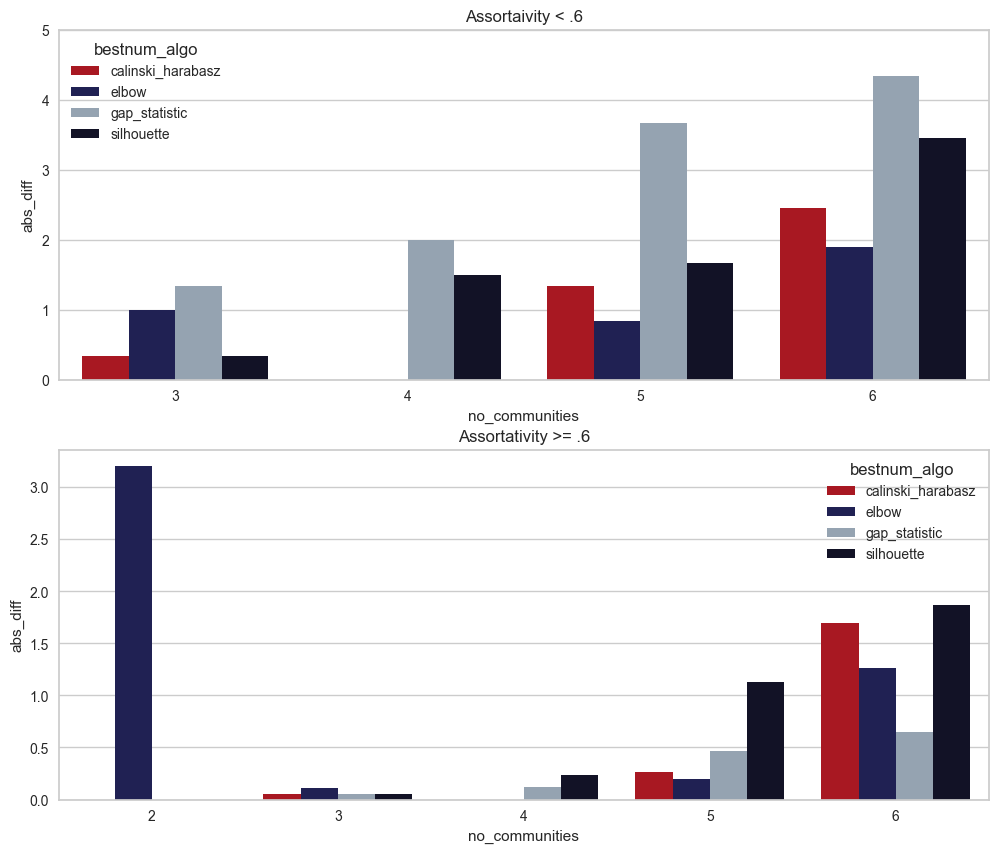

In [127]:
# plt.figure(figsize=(10, 4))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

subset = df_all_results[df_all_results['assortativity'] <.6]
sns.barplot(x='no_communities', y='abs_diff', hue='bestnum_algo', data=subset, estimator=np.mean, palette=mammalian_sighting_reflex, ci=None,ax=ax1)
general_avg = subset.groupby('layout_name')['abs_diff'].mean().reset_index()
# sns.pointplot(x='no_communities', y='abs_diff', data=general_avg, color=mammalian_sighting_reflex[0], markers='o', linestyles='', ax=ax1)
# Customize the plot
ax1.set_title('Assortaivity < .6')
ax1.set_ylim(0, 5)

# plt.xlabel('Bestnum Algorithm')
plt.ylabel('abs diff')
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed

subset = df_all_results[df_all_results['assortativity'] >=.6]
sns.barplot(x='no_communities', y='abs_diff', hue='bestnum_algo', data=subset, estimator=np.mean, palette=mammalian_sighting_reflex, ci=None, ax=ax2)
general_avg = subset.groupby('layout_name')['abs_diff'].mean().reset_index()
# sns.pointplot(x='no_communities', y='abs_diff', data=general_avg, color=mammalian_sighting_reflex[0], markers='o', linestyles='',ax=ax2)
# Customize the plot
ax2.set_title('Assortativity >= .6')
# plt.xlabel('Bestnum Algorithm')
plt.ylabel('abs_diff')
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.show()


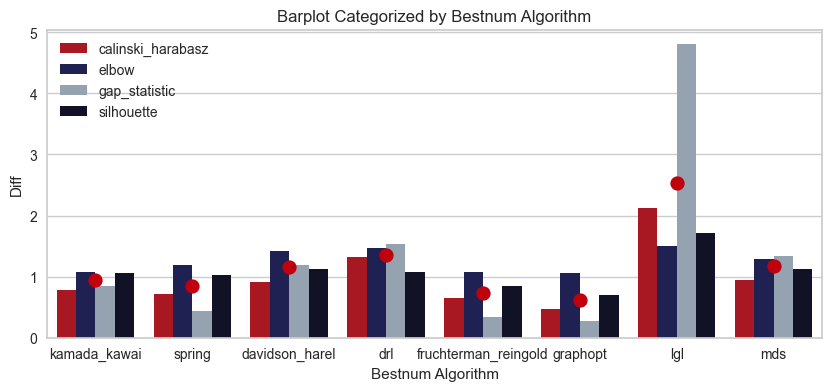

In [83]:
plt.figure(figsize=(10, 4))
subset = df_all_results[df_all_results['assortativity'] >=.6]
sns.barplot(x='layout_name', y='abs_diff', hue='bestnum_algo', data=subset, estimator=np.mean, palette=mammalian_sighting_reflex, ci=None)
general_avg = subset.groupby('layout_name')['abs_diff'].mean().reset_index()
sns.pointplot(x='layout_name', y='abs_diff', data=general_avg, color=mammalian_sighting_reflex[0], markers='o', linestyles='')
# Customize the plot
plt.title('Barplot Categorized by Bestnum Algorithm')
plt.xlabel('Bestnum Algorithm')
plt.ylabel('Diff')
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.show()

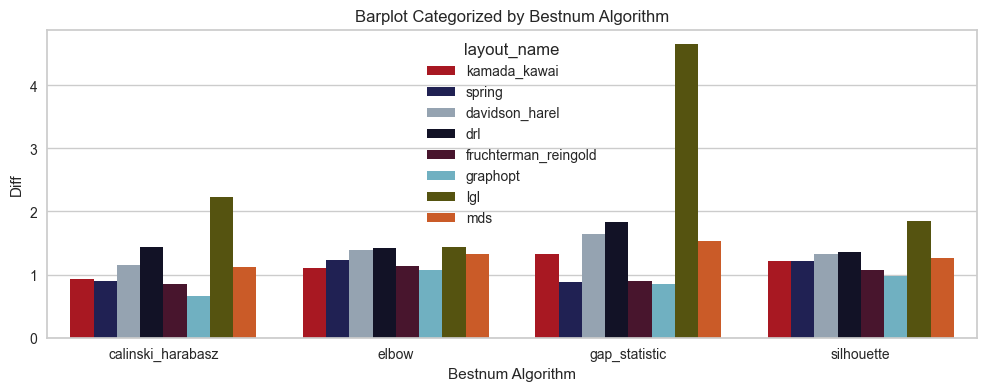

In [113]:
plt.figure(figsize=(12, 4))
sns.barplot(x='bestnum_algo', y='abs_diff', hue='layout_name', data=df_all_results, estimator=np.mean, palette=mammalian_sighting_reflex+wake_up_and_its_over, ci=None)
# general_avg = df_all_results.groupby('layout_name')['abs_diff'].mean().reset_index()
# sns.pointplot(x='layout_name', y='abs_diff', data=general_avg, color=mammalian_sighting_reflex[0], markers='o', linestyles='')
# Customize the plot
plt.title('Barplot Categorized by Bestnum Algorithm')
plt.xlabel('Bestnum Algorithm')
plt.ylabel('Diff')
# plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.show()

# Looking for the best algorithms for choosing the number of clusters for clustering

### Strukture experymentu:

* wygenerowac grafy różnych rozmiarow (smol, mid, large?) i roznego assortativity
* dokładniej: zrobic nowa funkcje do generowania grafów ktora przyjmuje assortativity i zaklada jakis bandwidth o ktory to moze sie wahac
- jak wykracza to wtedy generuje nowy graf (jesli sie źle wylosowało lol)
 lepszy pomysł -> moze generować grafy tak jak wychodzima, na czuja z ilością communities i probabilities i potem to pokategoryzować po assortativity
* jak wybrać ilość communities? może iść stepem co 2?
* wygenerwac posdf dla kazdego layoutu (do rozwazenia czy je potem jakos kategoryzowac czy nie )
* zebrać scory dla kazdego algortmu z osobna (I think?) zrobić dużo wykresów multidimensional dla analizy
* na koniec zebrać do kupy, zrobić boxploty and all


Pytanie czy tego w ogólnie zrobić obiektowo?

# Small graphs

In [3]:

#todo archieve
# for one graph
# ilość grafów - z palca napisać parametry w excelku, dla idk 20tu grafów i wczytywać jako parametry
size = 50
no_comms = 2
outside_prob = .5
inside_prob = .05

(G, true_labels) = generate_G_randomized(size, no_comms, outside_prob, inside_prob)
# pos = nx.kamada_kawai_layout(G)
# posdf = pd.DataFrame.from_dict(pos, orient='index', columns=['X', 'Y'])
assor = nx.numeric_assortativity_coefficient(G, "community")

# FOR GAP STATISTICS
num_clusters_dict = {}
layout_names = ['kamada_kawai', 'spring', 'davidson_harel', 'drl', 'fruchterman_reingold', 'graphopt', 'lgl','mds']
for layout_name in layout_names:
    num_clusters_dict[layout_name] = gap_statistic_best_num(posdf)

0.8086783403465908

A jesli obiektowo to jak?

analiza focusująca sie na analizie kazdego algorytmu osobno czy różnych algorytmow dla tego samego layoutu? 
chyba lepiej dla kazdego algorytmu z osobna

klasa -> eksperymenty dla np gap statistics, dla danego rodzaju grafów
obiekt -> experyment dla jednego graf
atrybuty -> wczytane z pliku parametry do generowania grafów (jako słownik moze? moze jako df bardziej)

chcecemy dla kazdego grafu policzyc best num dla kazdego layoutu -> wyniki trzymac jako graph id-assortativity - layout- best_num - real num

In [10]:
# graph_params = [
#     {'graph_id' : 0, 'size' : 50, 'no_comms' : 2, 'inside_prob':.8, 'outside_prob': .01},
#     {'graph_id' : 1, 'size' : 50, 'no_comms' : 2, 'inside_prob':.7, 'outside_prob': .01},
#     {'graph_id' : 2, 'size' : 50, 'no_comms' : 2, 'inside_prob':.75, 'outside_prob': .05},
#     {'graph_id' : 3, 'size' : 50, 'no_comms' : 2, 'inside_prob':.65, 'outside_prob': .05},
    
#     {'graph_id' : 0, 'size' : 50, 'no_comms' : 2, 'inside_prob':.8, 'outside_prob': .01},
#     {'graph_id' : 1, 'size' : 50, 'no_comms' : 2, 'inside_prob':.7, 'outside_prob': .01},
#     {'graph_id' : 2, 'size' : 50, 'no_comms' : 2, 'inside_prob':.75, 'outside_prob': .05},
#     {'graph_id' : 3, 'size' : 50, 'no_comms' : 2, 'inside_prob':.65, 'outside_prob': .05},
# ]
# graph_params = pd.DataFrame(graph_params)

# Class and main stuff

In [2]:
# graph_params = pd.read_excel(r'data\50_graph_params.xlsx')
# graph_params

In [1]:
from clustering_script import *
from graph_generating_script import *
from choosing_best_num_algorithms import *

In [7]:
from tqdm import tqdm 

class BestNumExperiment():
    def __init__(self, graph_params:pd.DataFrame):
        self.graph_params = graph_params
        self.graph_posdfs = {}

    def calculate_posdfs(self, from_file=None):
        if from_file==None:
            for _, row in tqdm(self.graph_params.iterrows(), total=self.graph_params.shape[0]):
                print(row['graph_id'])
                (G, true_labels) = generate_G_randomized(int(row['size']), int(row['no_comms']), row['inside_prob'], row['outside_prob'])
                self.graph_posdfs[row['graph_id']] = {}
                assor = nx.numeric_assortativity_coefficient(G, "community")
                self.graph_posdfs[row['graph_id']]['assortativity'] = assor
                layout_names = ['kamada_kawai', 'spring', 'davidson_harel', 'drl', 'fruchterman_reingold', 'graphopt', 'lgl','mds']
                for layout_name in layout_names:
                    posdf = posdf_from_layout(G, layout_name)
                    
                    # Store the posdf DataFrame in the nested dictionary
                    self.graph_posdfs[row['graph_id']][layout_name] = posdf
        else:
            self.graph_posdfs
    

    def make_experiment(self, best_num_algo_name):
        #iterating through all the graphs
        results = pd.DataFrame(columns=['graph_id', 'assortativity', 'layout_name', 'no_communities', 'calculated_bestnum'])
        for _, row in tqdm(self.graph_params.iterrows(), total=self.graph_params.shape[0]):
        # for _, row in self.graph_params.iterrows():
            # (G, true_labels) = generate_G_randomized(int(row['size']), int(row['no_comms']), row['inside_prob'], row['outside_prob'])
            # assor = nx.numeric_assortativity_coefficient(G, "community")
            layout_names = ['kamada_kawai', 'spring', 'davidson_harel', 'drl', 'fruchterman_reingold', 'graphopt', 'lgl','mds']
            for layout_name in layout_names:
                # posdf = posdf_from_layout(G, layout_name)
                posdf = self.graph_posdfs[row['graph_id']][layout_name]
                #todo change this so constructor takes a function as an argument intead of hardcoding
                if best_num_algo_name == 'gap_statistic':
                    (best_num, _) = gap_statistic_best_num(posdf)
                elif best_num_algo_name == 'elbow_method':
                    (best_num, _) = elbow_method_best_num(posdf)
                elif best_num_algo_name == 'silhouette':
                    (best_num, _) = silhouette_best_num(posdf)
                elif best_num_algo_name == 'calinski_harabasz':
                    (best_num, _) = calinski_harabasz_best_num(posdf)
                elif best_num_algo_name == 'BIC':
                    (best_num, _) = BIC_best_num(posdf)
                else:
                    raise ValueError('Incorrect algorith name, probably a typo')

                new_row = {'graph_id':[int(row['graph_id'])], 
                           'assortativity': [self.graph_posdfs[row['graph_id']]['assortativity']], 
                           'layout_name': [layout_name], 
                           'no_communities': [int(row['no_comms'])],
                            'calculated_bestnum':[int(best_num)]}
                # print(new_row)
                results = pd.concat([results, pd.DataFrame(new_row)])
                
        if best_num_algo_name == 'gap_statistic':
            self.gap= results
        elif best_num_algo_name == 'elbow_method':
            self.elbow = results
        elif best_num_algo_name == 'silhouette':
            self.silhouette = results
        elif best_num_algo_name == 'calinski_harabasz':
            self.ch = results
        elif best_num_algo_name == 'BIC':
            self.bic = results


# 50 nodes

In [6]:

graph_params = pd.read_excel(r'data\50_graph_params.xlsx')

ex1 = BestNumExperiment(graph_params)
ex1.calculate_posdfs()


100%|██████████| 31/31 [01:49<00:00,  3.52s/it]


In [13]:
import warnings
warnings.filterwarnings('ignore')


ex1.make_experiment('gap_statistic')
ex1.gap.to_excel(r'data\50_gap_results.xlsx', index=False)

100%|██████████| 31/31 [01:27<00:00,  2.81s/it]


In [7]:
ex1.make_experiment('elbow_method')
ex1.elbow.to_excel(r'data\50_elbow_results.xlsx', index=False)

  0%|          | 0/31 [00:00<?, ?it/s]  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
100%|██████████| 31/31 [01:11<00:00,  2.30s/it]


<Figure size 800x550 with 0 Axes>

In [8]:
ex1.make_experiment('silhouette')
ex1.silhouette.to_excel(r'data\50_silhouette_results.xlsx', index=False)

100%|██████████| 31/31 [01:07<00:00,  2.17s/it]


In [9]:
ex1.make_experiment('calinski_harabasz')
ex1.ch.to_excel(r'data\50_ch_results.xlsx', index=False)

100%|██████████| 31/31 [01:05<00:00,  2.12s/it]


In [12]:
# ex1.make_experiment('BIC')
# ex1.bic.to_excel(r'data\50_BIC_results.xlsx', index=False)

# 150 nodes

In [10]:
graph_params = pd.read_excel(r'data\150_graph_params.xlsx')

ex4 = BestNumExperiment(graph_params)
ex4.calculate_posdfs()

  0%|          | 0/28 [00:00<?, ?it/s]

0.0


  4%|▎         | 1/28 [04:11<1:53:06, 251.36s/it]

1.0


  7%|▋         | 2/28 [06:42<1:23:24, 192.48s/it]

2.0


 11%|█         | 3/28 [09:04<1:10:31, 169.25s/it]

3.0


 14%|█▍        | 4/28 [14:18<1:30:40, 226.68s/it]

4.0


 18%|█▊        | 5/28 [16:54<1:17:05, 201.09s/it]

5.0


 21%|██▏       | 6/28 [18:37<1:01:29, 167.70s/it]

6.0


 25%|██▌       | 7/28 [20:10<50:05, 143.14s/it]  

7.0


 29%|██▊       | 8/28 [22:35<47:54, 143.71s/it]

8.0


 32%|███▏      | 9/28 [24:15<41:14, 130.26s/it]

9.0


 36%|███▌      | 10/28 [26:43<40:40, 135.59s/it]

11.0


 39%|███▉      | 11/28 [28:08<34:04, 120.24s/it]

12.0


 43%|████▎     | 12/28 [29:48<30:23, 113.98s/it]

13.0


 46%|████▋     | 13/28 [31:17<26:37, 106.47s/it]

14.0


 50%|█████     | 14/28 [33:07<25:04, 107.45s/it]

15.0


 54%|█████▎    | 15/28 [34:36<22:07, 102.09s/it]

17.0


 57%|█████▋    | 16/28 [35:38<18:00, 90.04s/it] 

18.0


 61%|██████    | 17/28 [36:57<15:51, 86.50s/it]

19.0


 64%|██████▍   | 18/28 [37:38<12:10, 73.05s/it]

20.0


 68%|██████▊   | 19/28 [39:12<11:52, 79.18s/it]

21.0


 71%|███████▏  | 20/28 [40:58<11:36, 87.12s/it]

23.0


 75%|███████▌  | 21/28 [42:16<09:50, 84.38s/it]

24.0


 79%|███████▊  | 22/28 [43:59<09:00, 90.12s/it]

25.0


 82%|████████▏ | 23/28 [46:31<09:03, 108.77s/it]

26.0


 86%|████████▌ | 24/28 [47:22<06:05, 91.44s/it] 

27.0


 89%|████████▉ | 25/28 [48:41<04:22, 87.65s/it]

28.0


 93%|█████████▎| 26/28 [50:38<03:12, 96.34s/it]

29.0


 96%|█████████▋| 27/28 [52:28<01:40, 100.63s/it]

30.0


100%|██████████| 28/28 [54:17<00:00, 116.33s/it]


In [11]:
size='150'
ex4.make_experiment('gap_statistic')
ex4.gap.to_excel(fr'data\{size}_gap_results.xlsx', index=False)

ex4.make_experiment('elbow_method')
ex4.elbow.to_excel(fr'data\{size}_elbow_results.xlsx', index=False)
ex4.make_experiment('silhouette')
ex4.silhouette.to_excel(fr'data\{size}_silhouette_results.xlsx', index=False)
ex4.make_experiment('calinski_harabasz')
ex4.ch.to_excel(fr'data\{size}_ch_results.xlsx', index=False)

100%|██████████| 28/28 [01:21<00:00,  2.90s/it]


# 80 nodes

In [8]:
graph_params = pd.read_excel(r'data\80_graph_params.xlsx')

ex3 = BestNumExperiment(graph_params)
ex3.calculate_posdfs()

  0%|          | 0/28 [00:00<?, ?it/s]

0.0


  4%|▎         | 1/28 [00:24<11:14, 25.00s/it]

1.0


  7%|▋         | 2/28 [00:38<07:55, 18.28s/it]

2.0


 11%|█         | 3/28 [00:54<07:08, 17.16s/it]

3.0


 14%|█▍        | 4/28 [01:27<09:22, 23.43s/it]

4.0


 18%|█▊        | 5/28 [01:40<07:33, 19.73s/it]

5.0


 21%|██▏       | 6/28 [01:51<06:06, 16.67s/it]

6.0


 25%|██▌       | 7/28 [02:00<05:01, 14.36s/it]

7.0


 29%|██▊       | 8/28 [02:16<04:55, 14.76s/it]

8.0


 32%|███▏      | 9/28 [02:28<04:23, 13.89s/it]

9.0


 36%|███▌      | 10/28 [02:42<04:10, 13.92s/it]

11.0


 39%|███▉      | 11/28 [02:49<03:21, 11.85s/it]

12.0


 43%|████▎     | 12/28 [02:59<03:00, 11.25s/it]

13.0


 46%|████▋     | 13/28 [03:06<02:28,  9.87s/it]

14.0


 50%|█████     | 14/28 [03:14<02:12,  9.44s/it]

15.0


 54%|█████▎    | 15/28 [03:20<01:48,  8.35s/it]

17.0


 57%|█████▋    | 16/28 [03:26<01:30,  7.58s/it]

18.0


 61%|██████    | 17/28 [03:36<01:30,  8.26s/it]

19.0


 64%|██████▍   | 18/28 [03:40<01:11,  7.16s/it]

20.0


 68%|██████▊   | 19/28 [03:49<01:07,  7.49s/it]

21.0


 71%|███████▏  | 20/28 [03:59<01:06,  8.37s/it]

23.0


 75%|███████▌  | 21/28 [04:08<01:00,  8.59s/it]

24.0


 79%|███████▊  | 22/28 [04:17<00:52,  8.78s/it]

25.0


 82%|████████▏ | 23/28 [04:30<00:50, 10.10s/it]

26.0


 86%|████████▌ | 24/28 [04:36<00:35,  8.79s/it]

27.0


 89%|████████▉ | 25/28 [04:43<00:24,  8.27s/it]

28.0


 93%|█████████▎| 26/28 [04:52<00:16,  8.48s/it]

29.0


 96%|█████████▋| 27/28 [05:02<00:08,  8.88s/it]

30.0


100%|██████████| 28/28 [05:08<00:00, 11.03s/it]


In [9]:
size='80'
ex3.make_experiment('gap_statistic')
ex3.gap.to_excel(fr'data\{size}_gap_results.xlsx', index=False)

ex3.make_experiment('elbow_method')
ex3.elbow.to_excel(fr'data\{size}_elbow_results.xlsx', index=False)
ex3.make_experiment('silhouette')
ex3.silhouette.to_excel(fr'data\{size}_silhouette_results.xlsx', index=False)
ex3.make_experiment('calinski_harabasz')
ex3.ch.to_excel(fr'data\{size}_ch_results.xlsx', index=False)

  0%|          | 0/28 [00:00<?, ?it/s]  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
100%|██████████| 28/28 [01:08<00:00,  2.46s/it]


<Figure size 800x550 with 0 Axes>

# 100 nodes


In [12]:
# from graph_generating_script import *

# (G, true_labels) = generate_G_randomized(80, 2, .4, .01)
# print(nx.numeric_assortativity_coefficient(G, "community"))

In [13]:
# # lay = nx.spring_layout(G)
# nx.draw_spring(G)

In [14]:
# G_ig = ig.Graph.TupleList(nx.to_edgelist(G), directed=False)
# layout = G_ig.layout('davidson_harel')
# posdf = pd.DataFrame(layout.coords, columns=['X', 'Y'])


In [5]:
graph_params = pd.read_excel(r'data\100_graph_params.xlsx')

ex2 = BestNumExperiment(graph_params)
ex2.calculate_posdfs()

  0%|          | 0/28 [00:00<?, ?it/s]

0.0


  4%|▎         | 1/28 [00:51<23:14, 51.64s/it]

1.0


  7%|▋         | 2/28 [01:22<17:08, 39.54s/it]

2.0


 11%|█         | 3/28 [01:56<15:21, 36.85s/it]

3.0


 14%|█▍        | 4/28 [03:01<19:16, 48.20s/it]

4.0


 18%|█▊        | 5/28 [03:23<14:49, 38.69s/it]

5.0


 21%|██▏       | 6/28 [03:43<11:49, 32.26s/it]

6.0


 25%|██▌       | 7/28 [04:03<09:51, 28.16s/it]

7.0


 29%|██▊       | 8/28 [04:26<08:50, 26.51s/it]

8.0


 32%|███▏      | 9/28 [04:41<07:18, 23.08s/it]

9.0


 36%|███▌      | 10/28 [05:05<07:00, 23.38s/it]

11.0


 39%|███▉      | 11/28 [05:21<05:59, 21.14s/it]

12.0


 43%|████▎     | 12/28 [05:36<05:08, 19.27s/it]

13.0


 46%|████▋     | 13/28 [05:48<04:14, 16.96s/it]

14.0


 50%|█████     | 14/28 [06:08<04:10, 17.90s/it]

15.0


 54%|█████▎    | 15/28 [06:20<03:27, 15.94s/it]

17.0


 57%|█████▋    | 16/28 [06:30<02:52, 14.37s/it]

18.0


 61%|██████    | 17/28 [06:41<02:27, 13.42s/it]

19.0


 64%|██████▍   | 18/28 [06:47<01:51, 11.19s/it]

20.0


 68%|██████▊   | 19/28 [07:00<01:43, 11.47s/it]

21.0


 71%|███████▏  | 20/28 [07:18<01:47, 13.42s/it]

23.0


 75%|███████▌  | 21/28 [07:27<01:26, 12.31s/it]

24.0


 79%|███████▊  | 22/28 [07:42<01:18, 13.13s/it]

25.0


 82%|████████▏ | 23/28 [08:03<01:16, 15.34s/it]

26.0


 86%|████████▌ | 24/28 [08:12<00:54, 13.54s/it]

27.0


 89%|████████▉ | 25/28 [08:27<00:42, 14.08s/it]

28.0


 93%|█████████▎| 26/28 [08:47<00:31, 15.62s/it]

29.0


 96%|█████████▋| 27/28 [09:01<00:15, 15.27s/it]

30.0


100%|██████████| 28/28 [09:13<00:00, 19.76s/it]


In [6]:
import warnings
warnings.filterwarnings('ignore')

size='100'
ex2.make_experiment('gap_statistic')
ex2.gap.to_excel(fr'data\{size}_gap_results.xlsx', index=False)

  0%|          | 0/28 [00:00<?, ?it/s]  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Kinga\Anaconda3\envs\academic-weapon\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
100%|██████████| 28/28 [01:10<00:00,  2.50s/it]


In [7]:

ex2.make_experiment('elbow_method')
ex2.elbow.to_excel(fr'data\{size}_elbow_results.xlsx', index=False)
ex2.make_experiment('silhouette')
ex2.silhouette.to_excel(fr'data\{size}_silhouette_results.xlsx', index=False)
ex2.make_experiment('calinski_harabasz')
ex2.ch.to_excel(fr'data\{size}_ch_results.xlsx', index=False)

100%|██████████| 28/28 [00:53<00:00,  1.91s/it]


<Figure size 800x550 with 0 Axes>

# Archieve

In [27]:
import warnings
warnings.filterwarnings('ignore')
score_g, df = gap_statistic_best_num(posdf, nrefs=5, max_clusters=10)
print(score_g)

2


In [28]:
import warnings
warnings.filterwarnings('ignore')
(best_num, df) = elbow_method_best_num(posdf)
print(best_num)
print(df)

4
   k     score
0  2  7.996492
1  3  5.914154
2  4  3.982963
3  5  3.192195
4  6  2.621029
5  7  2.316917
6  8  1.901668
7  9  1.876612


In [29]:
(best_num, df) = silhouette_best_num(posdf)
print(best_num)
print(df)

2
   k     score
0  2  0.463041
1  3  0.359885
2  4  0.372341
3  5  0.357085
4  6  0.336744
5  7  0.315441
6  8  0.321615
7  9  0.325476


In [30]:
calinski_harabasz_best_num(posdf)

(np.int64(2),
    k      score
 0  2  57.453275
 1  3  48.224158
 2  4  50.265370
 3  5  48.724949
 4  6  44.797561
 5  7  43.490899
 6  8  43.386100
 7  9  52.084067)

In [31]:
BIC_best_num(posdf)

(np.int64(2),
 [('spherical', 2, np.float64(121.57660781642991)),
  ('spherical', 3, np.float64(132.6436272385236)),
  ('spherical', 4, np.float64(146.54387651157913)),
  ('spherical', 5, np.float64(156.38372102979488)),
  ('spherical', 6, np.float64(170.32191141030808)),
  ('spherical', 7, np.float64(179.9454582506544)),
  ('spherical', 8, np.float64(190.5849855848137)),
  ('spherical', 9, np.float64(210.755923916245)),
  ('tied', 2, np.float64(121.26207781149596)),
  ('tied', 3, np.float64(133.33666612170833)),
  ('tied', 4, np.float64(139.7481930234458)),
  ('tied', 5, np.float64(152.65197311725075)),
  ('tied', 6, np.float64(158.12517715266563)),
  ('tied', 7, np.float64(166.60452001608328)),
  ('tied', 8, np.float64(179.6869224208222)),
  ('tied', 9, np.float64(186.47072444904325)),
  ('diag', 2, np.float64(125.58207086227458)),
  ('diag', 3, np.float64(142.11122234114163)),
  ('diag', 4, np.float64(150.81995886127083)),
  ('diag', 5, np.float64(177.41605824528335)),
  ('diag', 6,